# BAO (DESI), SNe1a (PP), RDS, θ* : Flat LCDM

In [2]:
import os
from __future__ import division
import numpy as np
from numpy import *
from sys import *
import multiprocessing
import emcee
from scipy.optimize import minimize
from scipy import interpolate
from scipy.integrate import odeint
from scipy.integrate import quad
from math import log10
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator
from numpy.linalg import multi_dot
from scipy.interpolate import interp1d
from scipy.constants import c
from multiprocessing import Pool
from getdist import plots, MCSamples
import getdist
import pickle
from statsmodels.stats.stattools import durbin_watson

c_kms = c/1000
print(c_kms)


from scipy.interpolate import griddata


import time

# for monte carlo error propagation
from scipy.linalg import block_diag
from numpy.random import multivariate_normal as MN
import scipy.stats as st



299792.458


# DESI BAO Data Alone

In [3]:
# Prior knowledge

zd = 1059 # Redshift at drag epoch
Neff = 3.044 # number of neutrino degrees of freedom
wb = 0.02218 # Baryon density parameter 
wb_unc = 0.00055
om_ratio = wb/(2.469*10**(-5))
R = 3*wb/(4*2.469*10**(-5))


# We define the model here, flat LCDM
def omR(H0):
    return (1. + 0.2271*Neff) * 2.469 * 10**(-5.0)*(H0/100)**(-2.0) 
def Hz(z, om, H0):
    return H0 * np.sqrt(om*(1.+z)**(3.0) + omR(H0)*(1.+z)**4 + (1 - om - omR(H0)))
def f(z, om, H0):
    return H0/Hz(z, om, H0)
def rr(z, om, H0):
    return quad(lambda x: f(x, om, H0), 0, z,)[0]

# Define the function to integrate for drag-epoch sound horizon
def cs(z):
    return c_kms/np.sqrt(3.*(1. + (3*wb/((1. + z)*4*2.469*10**(-5)))))
def rd2(om, H0):
    return quad(lambda x: (cs(x)/Hz(x, om, H0)), zd, np.inf,)[0]

# The approximation for the drag-epoch sound horizon to cross-check

# def wm(om, H0):
    #return om*(H0/100)**2
# def rd2(om, H0):
   # return 147.05*(wm(om, H0)/0.1432)**(-0.23)*(Neff/3.04)**(-0.1)*(wb/0.02236)**(-0.13)


In [4]:
# We define the BAO theoretical functions

def dm(x, om, H0):
    return (299792.458/H0)*rr(x, om, H0)

def dh(x, om, H0):
    return 299792.458/Hz(x, om, H0)

def dv(x, om, H0):
    t1 = dm(x, om, H0)**2 * dh(x, om, H0) * x
    return t1**(1./3.)


In [5]:
# The chi^2 for each component

# BGS
def chi2a(om, H0):
    t1 = (dv(0.295, om, H0)/rd2(om, H0) -7.93)/0.15
    return t1**2

################################################################
# LRG 1
covmatb = [[0.0625, -0.0678625],[-0.0678625, 0.3721]]
inv_covb = np.linalg.inv(covmatb)

def chi2b(om, H0):
    resid = np.array([dm(0.510, om, H0)/rd2(om, H0) -13.62, dh(0.510, om, H0)/rd2(om, H0) -20.98])
    return resid.T@inv_covb@resid


################################################################
# LRG2
covmatc = [[0.1024, -0.08064],[-0.08064, 0.36]]
inv_covc = np.linalg.inv(covmatc)

def chi2c(om, H0):
    resid = np.array([dm(0.706, om, H0)/rd2(om, H0)-16.85, dh(0.706, om, H0)/rd2(om, H0)-20.08])
    return resid.T@inv_covc@resid


################################################################
# LRG+ELG
covmatd = [[0.0784, -0.038122],[-0.038122, 0.1225]]
inv_covd = np.linalg.inv(covmatd)

def chi2d(om, H0):
    resid = np.array([dm(0.930, om, H0)/rd2(om, H0)-21.71, dh(0.930, om, H0)/rd2(om, H0)-17.88])
    return resid.T@inv_covd@resid


################################################################
# ELG
covmate = [[0.4761, -0.1286712],[-0.1286712, 0.1764]]
inv_cove = np.linalg.inv(covmate)

def chi2e(om, H0):
    resid = np.array([dm(1.317, om, H0)/rd2(om, H0)-27.79, dh(1.317, om, H0)/rd2(om, H0)-13.82])
    return resid.T@inv_cove@resid


################################################################
# QSO
def chi2f(om, H0):
    t1 = (dv(1.491, om, H0)/rd2(om, H0)-26.07)/0.67
    return t1**2


################################################################
# Lya QSO
covmatg = [[0.8836, -0.0762246],[-0.0762246, 0.0289]]
inv_covg = np.linalg.inv(covmatg)

def chi2g(om, H0):
    resid = np.array([dm(2.330, om, H0)/rd2(om, H0)-39.71, dh(2.330, om, H0)/rd2(om, H0)-8.52])
    return resid.T@inv_covg@resid


In [6]:
def chitotal(H0, om):
    BAO = chi2a(om, H0)+chi2b(om, H0)+chi2c(om, H0)+chi2d(om, H0)+chi2e(om, H0)+chi2f(om, H0)+chi2g(om, H0)
    return BAO 

def lnprior(theta):
    H0, om = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om = theta
	model = chitotal(H0, om )      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)
    

In [6]:
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[70, 0.3],method='Nelder-Mead')
print('minimization 0.5*chi2 for DESI BAO data', rest.x)
result=rest.x
print("BAO: chi-squared =", -2*lnprob(result))
print("BAO: reduced chi-squared =",-2*lnprob(result)/(12-2))

searching the initial position ...
minimization 0.5*chi2 for DESI BAO data [68.87247173  0.28886218]
BAO: chi-squared = 13.598451338278377
BAO: reduced chi-squared = 1.3598451338278377


In [7]:
# # MCMC Sampling

# ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
# ndim, nwalkers = 2, 10
# nburn=20
# nmcmc=1000
# dres=[0.1, 0.01]

# pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
# pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

#  Clear and run the production chain.
# print("Running MCMC for DESI BAO data...")
# pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
# sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
# print("Done.")

Running MCMC for DESI BAO data...
Done.


Removed no burn in
MCMC result:
    $H0$        = 68.90517036986662 + 0.6806781387635823 -0.6251020714968263
    $\Omega_M$  = 0.2896644194786849 + 0.013999921210871458 -0.013574487443545502



<Figure size 5000x3000 with 0 Axes>

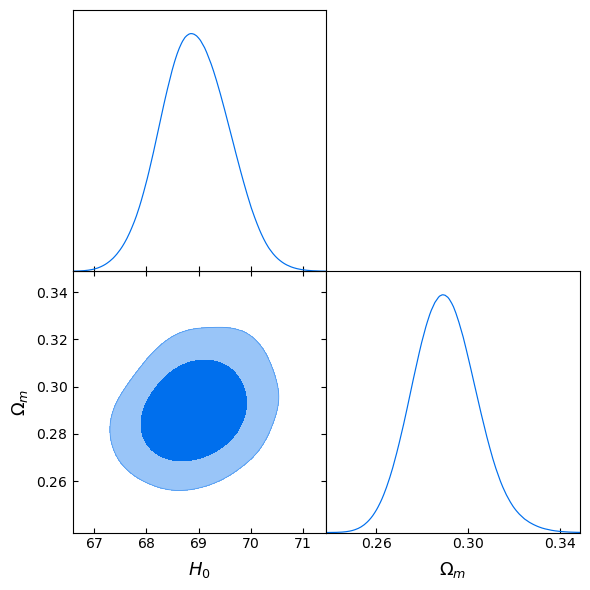

In [8]:
# # Here we neglect the first burnin samples
# burnin = 20
# samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))
# names = ["H_0", "\Omega_m"]
# labels = ["H_0", "\Omega_m"]

# samples = MCSamples(samples=samps, names=names, labels=labels)

# # Triangle plot
# g = plots.get_subplot_plotter(width_inch=6)
# pl.figure(figsize=(50,30))
# g.triangle_plot([samples], filled=True)
# g.export('hrd_vs_om_case_all.pdf')


# # Compute the quantiles.
# h0_mcmc, om_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
#                               zip(*np.percentile(samps, [16, 50, 84],
#                                                axis=0)))
# print("""MCMC result:
#    $H0$        = {0[0]} + {0[1]} -{0[2]}
#    $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
# """.format(h0_mcmc, om_mcmc))


## RDS Data Alone

In [7]:
# Adding growth pertubations data sets

datagf=loadtxt('Growth_tableII.txt',float)

# Redshift Space Distortions (RDS) sample
zgf = datagf[:,0]
gf  = datagf[:,1]
sgf = datagf[:,2]


#### RDS: Equation (2.5) for flat LCDM

In this case we solve for $\delta (a) $ given by the solution to

$$ \delta''+\left(\frac{3}{a}+ \frac{E'(a)}{E(a)} \right)\delta' - \frac{3}{2} \frac{\Omega_{0m}}{a^5E(a)^2} \delta = 0
$$

In [8]:

def model(delta, a, Omega0m):
    H = np.sqrt(Omega0m/a**3. + (1. - Omega0m))
    H_prime = (-3.*Omega0m/a**4.)/(2.*H)

    delta_prime = delta[1]
    delta_double_prime = -((3./a) + H_prime/H)*delta[1] + (1.5*Omega0m*delta[0]/(a**5*H**2))

    return [delta_prime, delta_double_prime]

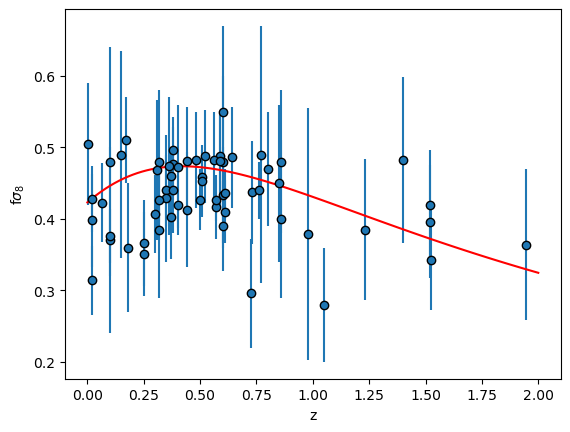

In [9]:
# Initial conditions
delta0 = 0.001  # initial value of delta
delta_prime0 = 1.0  # initial value of delta'


def Dadp(aa, Omega0m):
    # Solve the ODE
    a_values = np.linspace(0.001, 1, 1000)  # values of 'a' where you want to solve the ODE
    delta_solution = odeint(model, [delta0, delta_prime0], a_values, args=(Omega0m, ))
    delta_values, delta_prime_values = delta_solution[:, 0], delta_solution[:, 1]
    interpolation_delta = interp1d(a_values, delta_values, kind='linear', fill_value='extrapolate')
    interpolation_delta_prime = interp1d(a_values, delta_prime_values, kind='linear', fill_value='extrapolate')
    # Specify the x value for which you want to find the interpolated f value
    delta_f = interpolation_delta(aa)
    deltap_f = interpolation_delta_prime(aa)
    result = delta_f, deltap_f
    return result

def fa(aa, Omega0m):
    deltas = Dadp(aa, Omega0m)
    result = aa*deltas[1]/deltas[0]
    return result

def fs8z(z, Omega0m, sig8):
    aa = 1./(1.+z)
    deltas = Dadp(aa, Omega0m)
    daen1 = Dadp(1, Omega0m)
    t1 = sig8*deltas[0]*fa(1./(1.+z), Omega0m)
    t2 = t1/daen1[0]
    return t2

# Plot the data + theory (using best fit found below)
x = np.linspace(0, 2, 100)
fs8zd = fs8z(x, 0.31, 0.81)
pl.errorbar(zgf,gf,sgf,fmt='o',markeredgecolor='k')
pl.plot(x, fs8zd, color='red')
pl.xlabel('z')
pl.ylabel('f$\sigma_8$')
#pl.savefig('growthdata.png')    
pl.show()

In [10]:
# Chi squared minimization for RDS

def chi2_RDS(om, sig8):
    model = fs8z(zgf, om, sig8)
    inv_sigma2 = 1/(sgf**2)
    return np.sum(((gf - model)**2)*inv_sigma2)

def chi_total(om, sig8):
     return chi2_RDS(om, sig8)

def lnprior(theta):
    om, sig8 = theta
    if 0.1 < om < 0.5:
        return 0.0
    return -np.inf

def lnlike(theta):
	om, sig8 = theta
	model = chi_total(om, sig8)
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [46]:
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[0.31, 0.85],method='Nelder-Mead')
print('minimization 0.5*chi2 for RDS', rest.x)
result=rest.x
print("RDS: chi-squared =", -2*lnprob(result))
print("RDS: reduced chi-squared =",-2*lnprob(result)/(63-2))

searching the initial position ...
minimization 0.5*chi2 for RDS [0.27324986 0.78172579]
RDS: chi-squared = 31.163797356527297
RDS: reduced chi-squared = 0.5108819238774966


In [17]:
ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
ndim, nwalkers = 2, 10
nburn=20
nmcmc=1000

dres=[0.01, 0.01]



# pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
# pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# Clear and run the production chain.
# print("Running MCMC for RDS data ...")


# pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
# sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
# print("Done.")

Running MCMC for RDS data ...
Done.


Removed no burn in
MCMC result:
    $\Omega_M$  = 0.2735217106354501 + 0.03847355450446027 -0.03294001996615034
    $\Sigma_8$  = 0.7807524551382377 + 0.032304045405748716 -0.02748473645854621




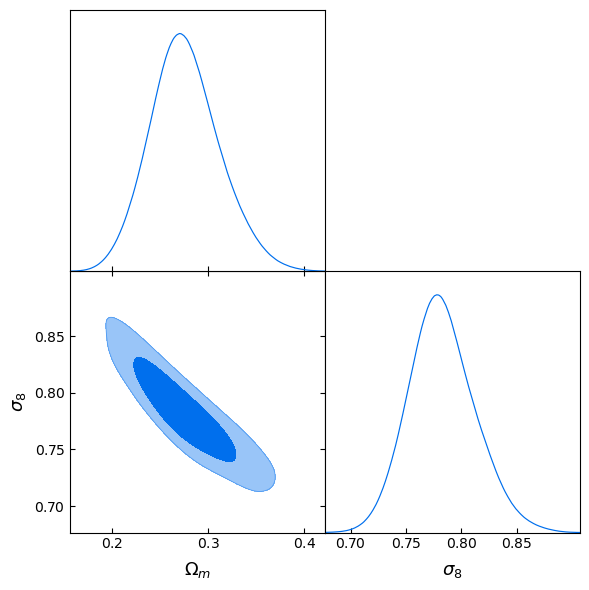

In [18]:
# #Here we neglect the first burnin samples
# burnin = 20
# samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))

# names = ["\Omega_m", "\sigma_8"]
# labels = ["\Omega_m", "\sigma_8"]

# samples = MCSamples(samples=samps, names=names, labels=labels)
# #Triangle plot
# g = plots.get_subplot_plotter(width_inch=6)
# pl.figure(figsize=(50,30))z
# g.triangle_plot([samples], filled=True)
# g.export('hrd_vs_om_case_all.pdf')
# #Compute the quantiles.
# om_mcmc, sig8_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
#                               zip(*np.percentile(samps, [16, 50, 84],
#                                                axis=0)))
# print("""MCMC result:
#     $\Omega_M$  = {0[0]} + {0[1]} -{0[2]}
#     $\Sigma_8$  = {1[0]} + {1[1]} -{1[2]}

# """.format(om_mcmc, sig8_mcmc))

## SN1a Data Alone

In [11]:
# Adding the Pantheon+SH0ES & Growth pertubations data sets

loc_lcparam = 'Pantheon+SH0ES.dat.txt'
lcparam = np.loadtxt(loc_lcparam, skiprows = 1, usecols = (2, 8, 9, 10, 11, 12, 13))
datagf=loadtxt('Growth_tableII.txt',float)

# Pantheon+ SN1a samples
z_pp = lcparam[:, 0]
mz_pp = lcparam[:, 1]
sigmz_pp = lcparam[:, 2]

mMz_pp = lcparam[:, 3]
sigmMz_pp = lcparam[:, 4]

muceph_pp = lcparam[:,5] # mu values calibrated using cepheids
hostyn_pp = lcparam[:,6] # 1 if calibrated, 0 if not

# Pantheon+ systematics
loc_lcparam_sys = 'Pantheon+SH0ES_STAT+SYS.cov.txt'
lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)
cov_pp_tot = lcparam_sys.reshape(1701, 1701)
inv_cov_pp = np.linalg.inv(cov_pp_tot)  # Covariance matrix inverse


In [12]:
# Definining theoretical function for SNe1a data

def dlh(z, om, H0):
    return rr(z, om, H0)*(1.0 + z)
def mMz_qd(z, H0, om):
    '''distance modulus prediction'''
    h_1 = H0/100
    return 5*np.log10((c/h_1)*dlh(z, om, H0))

def mz_qd(z, H0, om, M):
    '''apparent magnitude prediction'''
    return mMz_qd(z, H0, om) + M

In [13]:
# minimizing chi squared for SNE

def chi2_SN1a(H0, om, M):
    dm = np.zeros(len(z_pp))
    for i in range(0, len(z_pp)):
        if hostyn_pp[i] == 1:
            dm[i] = mz_pp[i] - M - muceph_pp[i] # SH0ES calibrated \mu
        else:
            dm[i] = mz_pp[i] - mz_qd(z_pp[i], H0, om, M)
    
    chi2 = dm @ inv_cov_pp @ dm
    return chi2


def chitotal(H0, om, M):
    SN1a = chi2_SN1a(H0, om, M)
    return SN1a

def lnprior(theta):
    H0, om, M = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, M = theta
	model = chitotal(H0, om, M)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)
    



In [ ]:
chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[73, 0.3, -19],method='Nelder-Mead')
print('minimization 0.5*chi2 for SNIa', rest.x)
result=rest.x
print("SN1a: chi-squared =", -2*lnprob(result))
print("SN1a: reduced chi-squared =",-2*lnprob(result)/(1701-3))

In [22]:
ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
ndim, nwalkers = 3, 10
nburn=20
nmcmc=1000

dres=[0.1, 0.01, 0.1]

#pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
#pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# Clear and run the production chain.
#print("Running MCMC for SN1a data ...")
#pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
#sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
#print("Done.")

Running MCMC for SN1a data ...
Done.


Removed no burn in
MCMC result:
    $H0$        = 73.41252276091018 + 1.0343426947458454 -0.9348820383685421
    $\Omega_M$  = 0.3335449401634324 + 0.019226888807450826 -0.01769074305464624
    $M$         = -19.24751984321925 + 0.02930245512560603 -0.026926580374048825




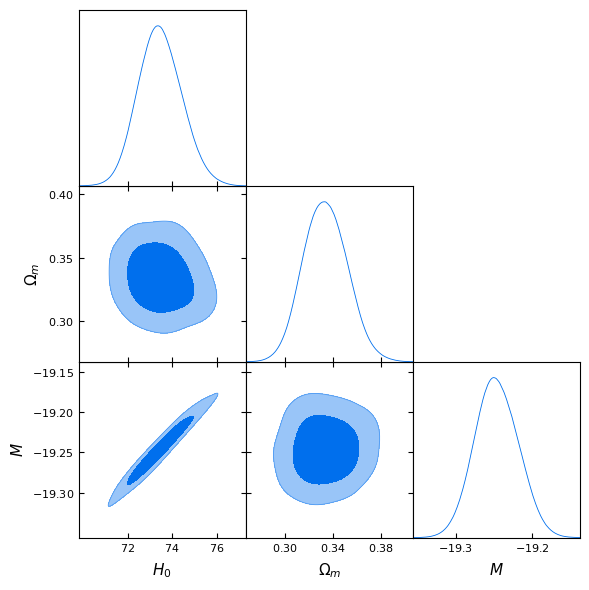

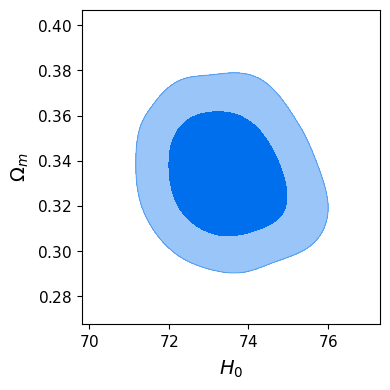

In [23]:
# # Here we neglect the first burnin samples
#burnin = 20
#samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))

# names = ["H_0", "\Omega_m", "M"]
# labels = ["H_0", "\Omega_m", "M"]

#samples = MCSamples(samples=samps, names=names, labels=labels)

# # Triangle plot
#g = plots.get_subplot_plotter(width_inch=6)
#pl.figure(figsize=(50,30))z
#g.triangle_plot([samples], filled=True)
#g.export('hrd_vs_om_case_all.pdf')

# # Filled 2D comparison plot with legend
#g = plots.get_single_plotter(width_inch=4, ratio=1)
#g.plot_2d([samples], 'H_0','\Omega_m', filled=True)
#g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# #Compute the quantiles.

#h0_mcmc, om_mcmc, M_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              #zip(*np.percentile(samps, [16, 50, 84],
                                               #axis=0)))
#print("""MCMC result:
#    $H0$        = {0[0]} + {0[1]} -{0[2]}
#   $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
#    $M$         = {2[0]} + {2[1]} -{2[2]}

#""".format(h0_mcmc, om_mcmc, M_mcmc))


## BAO + RDS

In [24]:
def chitotal(H0, om, sig8):
    BAO = chi2a(om, H0)+chi2b(om, H0)+chi2c(om, H0)+chi2d(om, H0)+chi2e(om, H0)+chi2f(om, H0)+chi2g(om, H0)
    RDS = chi2_RDS(om, sig8)
    return BAO + RDS

def lnprior(theta):
    H0, om, sig8 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, sig8 = theta
	model = chitotal(H0, om, sig8)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)

from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[70, 0.3, 0.8],method='Nelder-Mead')
print('minimization 0.5*chi2 for BAO + RDS', rest.x)
result=rest.x
print("BAO+RDS: chi-squared =", -2*lnprob(result))
print("BAO+RDS: reduced chi-squared =",-2*lnprob(result)/(75-3))

searching the initial position ...
minimization 0.5*chi2 for BAO + RDS [68.8577834   0.28680976  0.77216611]
BAO+RDS: chi-squared = 44.92638880670486
BAO+RDS: reduced chi-squared = 0.6239776223153453


In [25]:
ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
ndim, nwalkers = 3, 10
nburn=20
nmcmc=1000

dres=[0.1, 0.01, 0.01]

#pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
#pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# Clear and run the production chain.
#print("Running MCMC for BAO + RDS data ...")
#pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
#sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
#print("Done.")

Running MCMC for BAO + RDS data ...
Done.


Removed no burn in
MCMC result:
    $H0$        = 68.85953594413424 + 0.6649716607129648 -0.6107280101114725
    $\Omega_M$  = 0.28668784593404373 + 0.013968494667667308 -0.01207348303176281
    $\Sigma_8$  = 0.771484862509028 + 0.016182226827422097 -0.015676434032567688




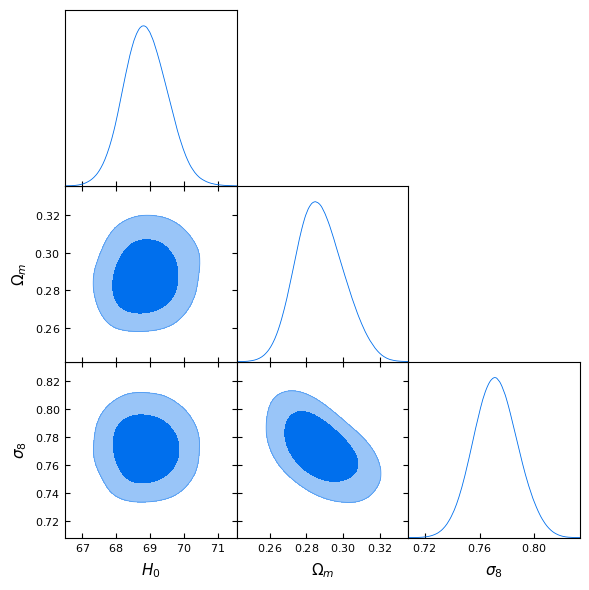

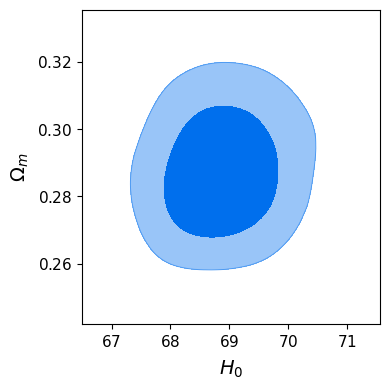

In [26]:
#burnin = 20
#samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))
#names = ["H_0", "\Omega_m", "\sigma_8"]
#labels = ["H_0", "\Omega_m", "\sigma_8"]

#samples = MCSamples(samples=samps, names=names, labels=labels)

# #Triangle plot
#g = plots.get_subplot_plotter(width_inch=6)
#g.triangle_plot([samples], filled=True)
#g.export('hrd_vs_om_case_all.pdf')

#g = plots.get_single_plotter(width_inch=4, ratio=1)
#g.plot_2d([samples], 'H_0','\Omega_m', filled=True)
#g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# #Compute the quantiles.
#h0_mcmc, om_mcmc, sig8_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              #zip(*np.percentile(samps, [16, 50, 84],
                                               #axis=0)))
#print("""MCMC result:
#    $H0$        = {0[0]} + {0[1]} -{0[2]}
#    $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
#    $\Sigma_8$  = {2[0]} + {2[1]} -{2[2]}

#""".format(h0_mcmc, om_mcmc, sig8_mcmc))


## BAO + SN1a

In [13]:
# Combining chi squares for each dataset

def chitotal(H0, om, M):
    BAO = chi2a(om, H0)+chi2b(om, H0)+chi2c(om, H0)+chi2d(om, H0)+chi2e(om, H0)+chi2f(om, H0)+chi2g(om, H0)
    SN1a = chi2_SN1a(H0, om, M)
    return BAO + SN1a 

def lnprior(theta):
    H0, om, M = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, M = theta
	model = chitotal(H0, om, M)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)
    
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[70, 0.3, -19],method='Nelder-Mead')
print('minimization 0.5*chi2 for BAO + SN1a', rest.x)
result=rest.x
print("BA0+SN1a: chi-squared =", -2*lnprob(result))
print("BAO+SN1a: reduced chi-squared =",-2*lnprob(result)/(1713-3))

searching the initial position ...
minimization 0.5*chi2 for BAO + SN1a [ 70.57559614   0.31529016 -19.33826337]
BA0+SN1a: chi-squared = 1554.64601456482
BAO+SN1a: reduced chi-squared = 0.9091497161197778


In [14]:
ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
ndim, nwalkers = 3, 10
nburn=20
nmcmc=1000

dres=[0.1, 0.01, 0.01]

#pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
#pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# Clear and run the production chain.
#print("Running MCMC for BAO + SN1a data ...")
#pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
#sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
#print("Done.")

Running MCMC for BAO + SN1a data ...
Done.


Removed no burn in
MCMC result:
    $H0$        = 70.59497130509297 + 0.609750801217487 -0.6063177648960902
    $\Omega_M$  = 0.31403038082008133 + 0.012049290706817262 -0.010551259892310705
    $\M$        = -19.338018768190093 + 0.019479352416148288 -0.019636802780070184




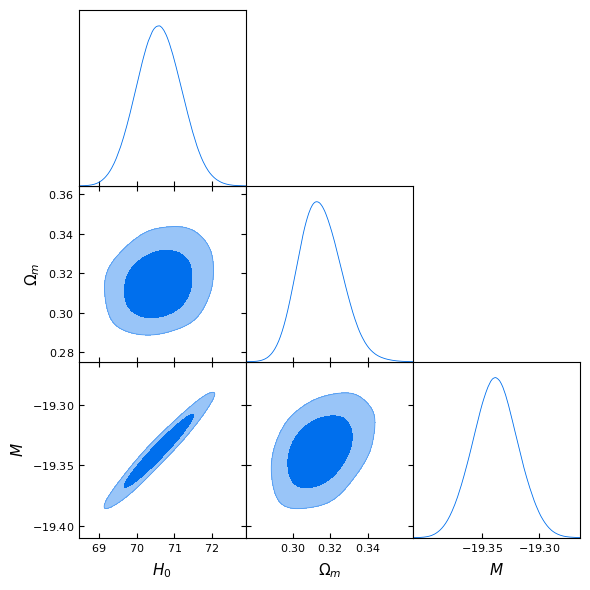

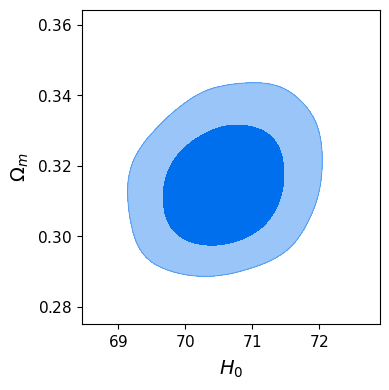

In [16]:
#burnin = 20
#samps_BS = sampler.chain[:, burnin:, :].reshape((-1, ndim))
#names_BS = ["H_0", "\Omega_m", "M"]
#labels_BS = ["H_0", "\Omega_m", "M"]

#samples_BS = MCSamples(samples=samps_BS, names=names_BS, labels=labels_BS)

# #vTriangle plot
#g = plots.get_subplot_plotter(width_inch=6)
#g.triangle_plot([samples_BS], filled=True)
#g.export('hrd_vs_om_case_all.pdf')

#g = plots.get_single_plotter(width_inch=4, ratio=1)
#g.plot_2d([samples_BS], 'H_0','\Omega_m', filled=True)
#g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# #Compute the quantiles.
#h0_mcmc, om_mcmc, M_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              #zip(*np.percentile(samps, [16, 50, 84],
                                               #axis=0)))
#print("""MCMC result:
#    $H0$        = {0[0]} + {0[1]} -{0[2]}
#    $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
#    $\M$        = {2[0]} + {2[1]} -{2[2]}

#""".format(h0_mcmc, om_mcmc, M_mcmc))


## BAO + RDS + SN1a 

In [14]:
# Combining chi squares for each dataset

def chitotal(H0, om, M, sig8):
    BAO = chi2a(om, H0)+chi2b(om, H0)+chi2c(om, H0)+chi2d(om, H0)+chi2e(om, H0)+chi2f(om, H0)+chi2g(om, H0)
    SN1a = chi2_SN1a(H0, om, M)
    RDS = chi2_RDS(om, sig8)
    return BAO + SN1a + RDS


def lnprior(theta):
    H0, om, M, sig8 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, M, sig8 = theta
	model = 0.5*chitotal(H0, om, M, sig8)  # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)


    

In [34]:
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[70, 0.3, -19, 0.8],method='Nelder-Mead')
print('minimization 0.5*chi2 for BAO + SN1a + RDS', rest.x)
result=rest.x

searching the initial position ...
minimization 0.5*chi2 for BAO + SN1a + RDS [ 70.4465457    0.3149407  -19.34229088   0.75442163]


In [35]:
ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
ndim, nwalkers = 4, 10
nburn=20
nmcmc=5000

dres=[0.1, 0.01, 0.1, 0.01]

#pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
#samplerBSR = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

from multiprocessing import Pool

print("Running MCMC...")
with Pool() as pool:
    samplerBSR = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
    pos1=samplerBSR.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
    samplerBSR.run_mcmc(pos1, nmcmc, progress=True)


# Clear and run the production chain.
#print("Running MCMC for BAO + SN1a + RDS data ...")
#pos1=samplerBSR.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
#samplerBSR.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
#print("Done.")

Running MCMC...


100%|███████████████████████████████████████| 5000/5000 [45:18<00:00,  1.84it/s]


Removed no burn in
MCMC result:
    $H0$        = 70.41937150830745 + 0.8436901270096655 -0.8123684738161501
    $\Omega_M$  = 0.3164572310072599 + 0.016211895961602607 -0.016347134349737003
    $M$         = -19.342277679929463 + 0.027117987601982918 -0.02670274044345078
    $\Sigma_8$  = 0.7543123147332517 + 0.020795884917009122 -0.021370838533372294





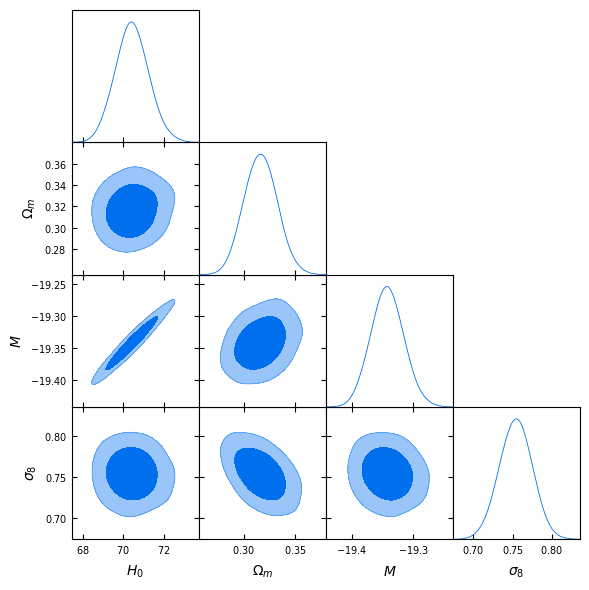

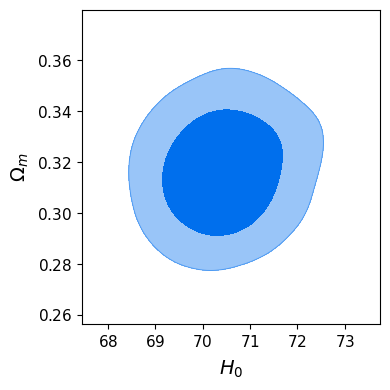

In [36]:
# Here we neglect the first burnin samples
burnin = 20
samps_BSR = samplerBSR.chain[:, burnin:, :].reshape((-1, ndim))

# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity

names_BSR = ["H_0", "\Omega_m", "M", "\sigma_8"]
labels_BSR = ["H_0", "\Omega_m", "M", "\sigma_8"]

samples_BSR = MCSamples(samples=samps_BSR, names=names_BSR, labels=labels_BSR)

# Triangle plot
g = plots.get_subplot_plotter(width_inch=6)
#pl.figure(figsize=(50,30))z
g.triangle_plot([samples_BSR], filled=True)
g.export('hrd_vs_om_case_all.pdf')

# Filled 2D comparison plot with legend
g = plots.get_single_plotter(width_inch=4, ratio=1)
g.plot_2d([samples_BSR], 'H_0','\Omega_m', filled=True)
#g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Compute the quantiles.

h0_mcmc, om_mcmc, M_mcmc, sig8_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(samps_BSR, [16, 50, 84],
                                               axis=0)))
print("""MCMC result:
    $H0$        = {0[0]} + {0[1]} -{0[2]}
    $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
    $M$         = {2[0]} + {2[1]} -{2[2]}
    $\Sigma_8$  = {3[0]} + {3[1]} -{3[2]}


""".format(h0_mcmc, om_mcmc, M_mcmc, sig8_mcmc))



# # Theta* Alone

In [15]:
# Additional Priors: acoustic angular scale & drag-epoch sound horizon

# Defining the acoustic angular scale
z_recomb = 1090
def rd2theta(z, om, H0):
    return quad(lambda x: (cs(x)/Hz(x, om, H0)), z, np.inf,)[0]

def angle(z, om, H0):
    return 100*rd2theta(z, om, H0)/dm(z, om, H0)

def chitotal(om, H0):
    return ((angle(z_recomb, om, H0)-1.04109)/0.00030)**2.

def lnprior(theta):
    om, H0 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	om, H0 = theta
	model = chitotal(om, H0)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)



In [38]:
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[0.3, 70],method='Nelder-Mead')
print('minimization 0.5*chi2 for theta*', rest.x)
result=rest.x
print("theta: chi-squared =", -2*lnprob(result))
print("theta: reduced chi-squared =",-2*lnprob(result)/(1-2))

searching the initial position ...
minimization 0.5*chi2 for theta* [ 0.30877146 67.74160734]
theta: chi-squared = 6.262219454296618e-16
theta: reduced chi-squared = -6.262219454296618e-16


In [37]:
ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
ndim, nwalkers = 2, 10
nburn=20
nmcmc=1000

dres=[0.01, 0.1]

#pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
#pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)

# Clear and run the production chain.
#print("Running MCMC for theta*...")
#pos1=sampler.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
#sampler.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
#print("Done.")


Running MCMC for theta*...
Done.


Removed no burn in
MCMC result:
    $\Omega_M$  = 0.33485083052693154 + 0.0630290936209057 -0.047024368416317186
    $H0$        = 63.6257377936717 + 3.0202533813121164 -3.3110392694845885

9.167926817617308e-05


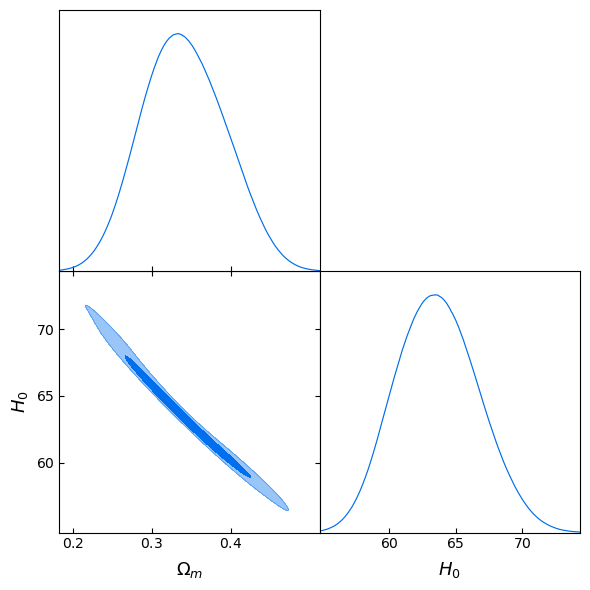

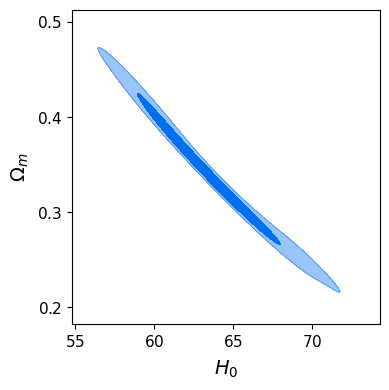

In [38]:
# Here we neglect the first burnin samples
burnin = 20
#samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))

# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity

names = ["\Omega_m", "H_0"]
labels = ["\Omega_m", "H_0"]

#samples = MCSamples(samples=samps, names=names, labels=labels)

# Triangle plot
#g = plots.get_subplot_plotter(width_inch=6)
#pl.figure(figsize=(50,30))z
#g.triangle_plot([samples], filled=True)
#g.export('hrd_vs_om_case_all.pdf')

# Filled 2D comparison plot with legend
#g = plots.get_single_plotter(width_inch=4, ratio=1)
#g.plot_2d([samples], 'H_0','\Omega_m', filled=True)
#g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Compute the quantiles.

#om_mcmc, h0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              #zip(*np.percentile(samps, [16, 50, 84],
                                               #axis=0)))
#print("""MCMC result:
#    $\Omega_M$  = {0[0]} + {0[1]} -{0[2]}
#    $H0$        = {1[0]} + {1[1]} -{1[2]}
#""".format(om_mcmc, h0_mcmc))


# # Combining theta* w/ 3 datasets

In [16]:

def chitotal(H0, om, M, sig8):
    BAO = chi2a(om, H0)+chi2b(om, H0)+chi2c(om, H0)+chi2d(om, H0)+chi2e(om, H0)+chi2f(om, H0)+chi2g(om, H0)
    SN1a = chi2_SN1a(H0, om, M)
    RDS = chi2_RDS(om, sig8)
    return BAO + SN1a + RDS + ((angle(z_recomb, om, H0)-1.04109)/0.00030)**2.

def lnprior(theta):
    H0, om, M, sig8 = theta
    if 0.0 < om < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta):
	H0, om, M, sig8 = theta
	model = chitotal(H0, om, M, sig8)      # Here we change the chi2 for each case
	return -0.5*model

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lnlike(theta)    # lp + lnlike(theta)

def resids(H0, om, M, sig8):
    residstot = np.concatenate((resids_BAO(om, H0), resids_SN1a(H0, om, M), resids_RDS(om, sig8)))
    return residstot

In [40]:
from scipy.optimize import minimize

chimint=lambda x: -lnprob(x)
print('searching the initial position ...')
rest=minimize(chimint,[70, 0.3, -19, 0.8],method='Nelder-Mead')
print('minimization 0.5*chi2 for BAO + SN1a + RDS', rest.x)
result=rest.x

searching the initial position ...
minimization 0.5*chi2 for BAO + SN1a + RDS [ 69.33960227   0.28607194 -19.38562147   0.77267031]


In [41]:

ncores = multiprocessing.cpu_count() # Count the number of cores in a computer cores
ndim, nwalkers = 4, 10
nburn=20
nmcmc=5000

dres=[0.1, 0.01, 0.1, 0.01]

#pos0 = [result+0.01*np.random.randn(ndim) for i in range(nwalkers)]
pos0 = [result+dres*np.random.randn(ndim) for i in range(nwalkers)]
#samplerBSRT = emcee.EnsembleSampler(nwalkers, ndim, lnprob,threads=ncores)


from multiprocessing import Pool

print("Running MCMC...")
with Pool() as pool:
    samplerBSRT = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
    pos1=samplerBSRT.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
    samplerBSRT.run_mcmc(pos1, nmcmc, progress=True)




# Clear and run the production chain.
#print("Running MCMC for BAO + SN1a + RDS + theta data ...")
#pos1=samplerBSRT.run_mcmc(pos0, nburn, rstate0=np.random.get_state())
#samplerBSRT.run_mcmc(pos1, nmcmc, rstate0=np.random.get_state())
#print("Done.")


Running MCMC...


100%|███████████████████████████████████████| 5000/5000 [45:19<00:00,  1.84it/s]


Removed no burn in
MCMC result:
    $H0$        = 69.33086117018817 + 0.4295663644557379 -0.4262296820930658
    $\Omega_M$  = 0.28615204793057014 + 0.005913504200970143 -0.005790933806628651
    $M$         = -19.38561158844163 + 0.011628388645707588 -0.011816934520386013
    $\Sigma_8$  = 0.7723260770576132 + 0.014427202561185126 -0.013819545675823108



9.167926817617308e-05


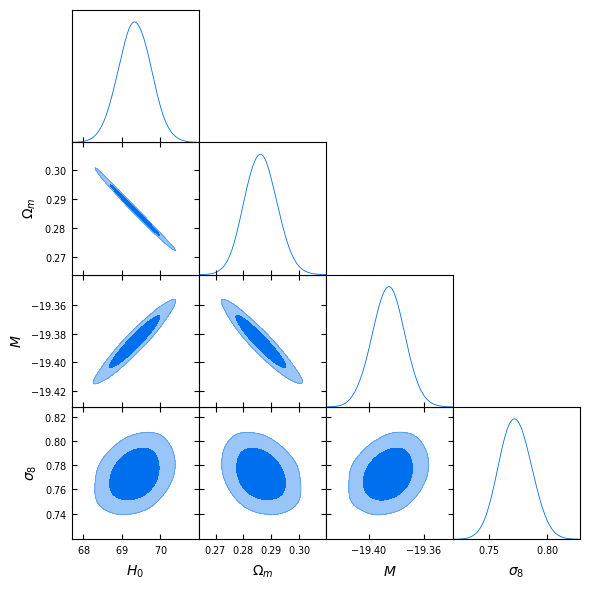

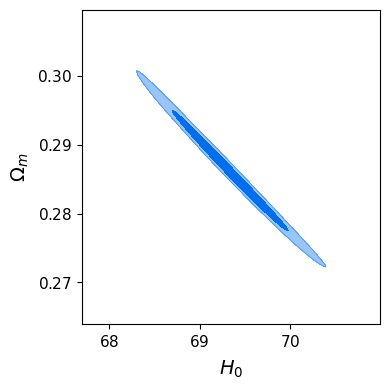

In [42]:
# Here we neglect the first burnin samples
burnin = 20
samps_BSRT = samplerBSRT.chain[:, burnin:, :].reshape((-1, ndim))

# Get the getdist MCSamples objects for the samples, specifying same parameter
# names and labels; if not specified weights are assumed to all be unity

names_BSRT  = ["H_0", "\Omega_m", "M", "\sigma_8"]
labels_BSRT  = ["H_0", "\Omega_m", "M", "\sigma_8"]

samples_BSRT = MCSamples(samples=samps_BSRT , names=names_BSRT , labels=labels_BSRT )

# Triangle plot
g = plots.get_subplot_plotter(width_inch=6)
#pl.figure(figsize=(50,30))z

g.triangle_plot([samples_BSRT], filled=True)



# Filled 2D comparison plot with legend
g = plots.get_single_plotter(width_inch=4, ratio=1)
g.plot_2d([samples_BSRT], 'H_0','\Omega_m', filled=True)
#g.add_legend(['sim 1', 'sim 2'], colored_text=True);

# Compute the quantiles.

h0_mcmc, om_mcmc, M_mcmc, sig8_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(samps_BSRT , [16, 50, 84],
                                               axis=0)))
print("""MCMC result:
    $H0$        = {0[0]} + {0[1]} -{0[2]}
    $\Omega_M$  = {1[0]} + {1[1]} -{1[2]}
    $M$         = {2[0]} + {2[1]} -{2[2]}
    $\Sigma_8$  = {3[0]} + {3[1]} -{3[2]}


""".format(h0_mcmc, om_mcmc, M_mcmc, sig8_mcmc))

print(omR(67.48920691828434))

# Statistical analysis of model with best-fit parameters

In [17]:
# Durbin-Watson statistic 
def resids_BAO(om, H0): 
    return np.array([dv(0.3, om, H0)/rd2(om, H0) -7.93, dm(0.51, om, H0)/rd2(om, H0) -13.62, dh(0.51, om, H0)/rd2(om, H0) -20.98, dm(0.71, om, H0)/rd2(om, H0)-16.85, dh(0.71, om, H0)/rd2(om, H0)-20.08, dm(0.93, om, H0)/rd2(om, H0)-21.71, dh(0.93, om, H0)/rd2(om, H0)-17.88, dm(1.32, om, H0)/rd2(om, H0)-27.79, dh(1.32, om, H0)/rd2(om, H0)-13.82, dv(1.49, om, H0)/rd2(om, H0)-26.07, dm(2.33, om, H0)/rd2(om, H0)-39.71, dh(2.33, om, H0)/rd2(om, H0)-8.52])

def resids_SN1a(H0, om, M):
    dm = np.zeros(len(z_pp))
    for i in range(0, len(z_pp)):
        if hostyn_pp[i] == 1:
            dm[i] = mz_pp[i] - M - muceph_pp[i] # SH0ES calibrated \mu
        else:
            dm[i] = mz_pp[i] - mz_qd(z_pp[i], H0, om, M)
    return dm

def resids_RDS(om, sig8):
    model = fs8z(zgf, om, sig8)
    return (gf - model)
    
def resids(H0, om, M, sig8):
    residstot = np.concatenate((resids_BAO(om, H0), resids_SN1a(H0, om, M), resids_RDS(om, sig8)))
    return residstot



In [18]:

# Flat LCDM
def chitotal(H0, om, M, sig8):
    BAO = chi2a(om, H0)+chi2b(om, H0)+chi2c(om, H0)+chi2d(om, H0)+chi2e(om, H0)+chi2f(om, H0)+chi2g(om, H0)
    SN1a = chi2_SN1a(H0, om, M)
    RDS = chi2_RDS(om, sig8)
    return BAO + SN1a + RDS
print("BAO+RDS+SN1a: chi-squared =", chitotal(70.59, 0.311, -19.34, 0.757))
print("BAO+RDS+SN1a: reduced chi-squared =",chitotal(70.59, 0.311, -19.34, 0.757)/(1776-4))
print("BAO+RDS+SN1a: DW statistic =", durbin_watson(resids(70.59, 0.311, -19.34, 0.757)))


BAO+RDS+SN1a: chi-squared = 1586.5747843664744
BAO+RDS+SN1a: reduced chi-squared = 0.895358230455121
BAO+RDS+SN1a: DW statistic = 1.6811628705253583


In [21]:

# Flat LCDM w/ theta*
def chitotal(H0, om, M, sig8):
    BAO = chi2a(om, H0)+chi2b(om, H0)+chi2c(om, H0)+chi2d(om, H0)+chi2e(om, H0)+chi2f(om, H0)+chi2g(om, H0)
    SN1a = chi2_SN1a(H0, om, M)
    RDS = chi2_RDS(om, sig8)
    return BAO + SN1a + RDS + ((angle(z_recomb, om, H0)-1.04109)/0.00030)**2.
print("BAO+RDS+SN1a+theta*: chi-squared =", chitotal(69.35, 0.286, -19.31, 0.771))
print("BAO+RDS+SN1a+theta*: reduced chi-squared =",chitotal(69.35, 0.286, -19.31, 0.771)/(1776-5))
print("BAO+RDS+SN1a+theta*: DW statistic =", durbin_watson(resids(69.35, 0.286, -19.31, 0.771)))


BAO+RDS+SN1a+theta*: chi-squared = 2023.597859342824
BAO+RDS+SN1a+theta*: reduced chi-squared = 1.1426300730337797
BAO+RDS+SN1a+theta*: DW statistic = 1.4874279521558642


In [22]:
# Flat LCDM w/ theta*
def chitotal(H0, om, M, sig8):
    BAO = chi2a(om, H0)+chi2b(om, H0)+chi2c(om, H0)+chi2d(om, H0)+chi2e(om, H0)+chi2f(om, H0)+chi2g(om, H0)
    SN1a = chi2_SN1a(H0, om, M)
    RDS = chi2_RDS(om, sig8)
    return BAO + SN1a + RDS + ((angle(z_recomb, om, H0)-1.04109)/0.00030)**2.
print("BAO+RDS+SN1a+theta*: chi-squared =", chitotal(69.35, 0.286, -19.39, 0.771))
print("BAO+RDS+SN1a+theta*: reduced chi-squared =",chitotal(69.35, 0.286, -19.39, 0.771)/(1776-5))
print("BAO+RDS+SN1a+theta*: DW statistic =", durbin_watson(resids(69.35, 0.286, -19.39, 0.771)))

BAO+RDS+SN1a+theta*: chi-squared = 1598.0260088808618
BAO+RDS+SN1a+theta*: reduced chi-squared = 0.9023297622139254
BAO+RDS+SN1a+theta*: DW statistic = 1.6970822063768036
